# Deep Reinforcement Learning (Q-Learning)
### Nick Koutroumpinis, ML|mind Software Development

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-08-30 17:17:43,603] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
env.close()

In [5]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
train_episodes = 1000        # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [19]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [20]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 4.0 Training loss: 1.0574 Explore P: 0.9996
Episode: 2 Total reward: 11.0 Training loss: 1.0596 Explore P: 0.9985
Episode: 3 Total reward: 37.0 Training loss: 1.0773 Explore P: 0.9949
Episode: 4 Total reward: 27.0 Training loss: 1.0169 Explore P: 0.9922
Episode: 5 Total reward: 9.0 Training loss: 1.0914 Explore P: 0.9913
Episode: 6 Total reward: 18.0 Training loss: 1.1281 Explore P: 0.9896
Episode: 7 Total reward: 28.0 Training loss: 1.0590 Explore P: 0.9868
Episode: 8 Total reward: 27.0 Training loss: 1.2827 Explore P: 0.9842
Episode: 9 Total reward: 11.0 Training loss: 1.1534 Explore P: 0.9831
Episode: 10 Total reward: 19.0 Training loss: 1.2140 Explore P: 0.9813
Episode: 11 Total reward: 16.0 Training loss: 1.2016 Explore P: 0.9797
Episode: 12 Total reward: 14.0 Training loss: 1.3894 Explore P: 0.9784
Episode: 13 Total reward: 39.0 Training loss: 1.2618 Explore P: 0.9746
Episode: 14 Total reward: 13.0 Training loss: 1.3887 Explore P: 0.9733
Episode: 15 Total

Episode: 124 Total reward: 30.0 Training loss: 66.5743 Explore P: 0.8081
Episode: 125 Total reward: 9.0 Training loss: 75.7694 Explore P: 0.8074
Episode: 126 Total reward: 11.0 Training loss: 68.8317 Explore P: 0.8065
Episode: 127 Total reward: 22.0 Training loss: 87.0924 Explore P: 0.8047
Episode: 128 Total reward: 23.0 Training loss: 6.0446 Explore P: 0.8029
Episode: 129 Total reward: 14.0 Training loss: 119.8153 Explore P: 0.8018
Episode: 130 Total reward: 22.0 Training loss: 48.4505 Explore P: 0.8001
Episode: 131 Total reward: 33.0 Training loss: 98.1121 Explore P: 0.7975
Episode: 132 Total reward: 26.0 Training loss: 63.8660 Explore P: 0.7954
Episode: 133 Total reward: 7.0 Training loss: 28.8449 Explore P: 0.7949
Episode: 134 Total reward: 18.0 Training loss: 132.8828 Explore P: 0.7934
Episode: 135 Total reward: 11.0 Training loss: 5.1591 Explore P: 0.7926
Episode: 136 Total reward: 20.0 Training loss: 54.2129 Explore P: 0.7910
Episode: 137 Total reward: 12.0 Training loss: 5.1534

Episode: 238 Total reward: 74.0 Training loss: 1.4466 Explore P: 0.6345
Episode: 239 Total reward: 41.0 Training loss: 8.8917 Explore P: 0.6319
Episode: 240 Total reward: 36.0 Training loss: 17.2158 Explore P: 0.6297
Episode: 241 Total reward: 42.0 Training loss: 15.4346 Explore P: 0.6271
Episode: 242 Total reward: 22.0 Training loss: 1.1587 Explore P: 0.6257
Episode: 243 Total reward: 33.0 Training loss: 29.1788 Explore P: 0.6237
Episode: 244 Total reward: 14.0 Training loss: 26.5936 Explore P: 0.6228
Episode: 245 Total reward: 20.0 Training loss: 11.5184 Explore P: 0.6216
Episode: 246 Total reward: 27.0 Training loss: 0.7213 Explore P: 0.6200
Episode: 247 Total reward: 28.0 Training loss: 1.0239 Explore P: 0.6183
Episode: 248 Total reward: 40.0 Training loss: 18.2101 Explore P: 0.6158
Episode: 249 Total reward: 16.0 Training loss: 11.8363 Explore P: 0.6149
Episode: 250 Total reward: 29.0 Training loss: 1.0189 Explore P: 0.6131
Episode: 251 Total reward: 36.0 Training loss: 15.6901 Ex

Episode: 352 Total reward: 51.0 Training loss: 2.0619 Explore P: 0.4019
Episode: 353 Total reward: 86.0 Training loss: 55.7333 Explore P: 0.3985
Episode: 354 Total reward: 84.0 Training loss: 119.3599 Explore P: 0.3953
Episode: 355 Total reward: 32.0 Training loss: 51.0197 Explore P: 0.3940
Episode: 356 Total reward: 42.0 Training loss: 21.1243 Explore P: 0.3924
Episode: 357 Total reward: 44.0 Training loss: 1.5987 Explore P: 0.3907
Episode: 358 Total reward: 92.0 Training loss: 25.2921 Explore P: 0.3872
Episode: 359 Total reward: 100.0 Training loss: 40.6336 Explore P: 0.3835
Episode: 360 Total reward: 46.0 Training loss: 1.4816 Explore P: 0.3818
Episode: 361 Total reward: 67.0 Training loss: 34.0117 Explore P: 0.3793
Episode: 362 Total reward: 40.0 Training loss: 1.3656 Explore P: 0.3778
Episode: 363 Total reward: 52.0 Training loss: 60.7896 Explore P: 0.3759
Episode: 364 Total reward: 60.0 Training loss: 1.8688 Explore P: 0.3737
Episode: 365 Total reward: 39.0 Training loss: 117.226

Episode: 465 Total reward: 147.0 Training loss: 0.8118 Explore P: 0.1507
Episode: 466 Total reward: 152.0 Training loss: 0.7656 Explore P: 0.1486
Episode: 467 Total reward: 107.0 Training loss: 181.6931 Explore P: 0.1471
Episode: 468 Total reward: 199.0 Training loss: 0.7669 Explore P: 0.1444
Episode: 469 Total reward: 167.0 Training loss: 1.7932 Explore P: 0.1422
Episode: 470 Total reward: 164.0 Training loss: 0.6325 Explore P: 0.1400
Episode: 471 Total reward: 152.0 Training loss: 1.7691 Explore P: 0.1381
Episode: 472 Total reward: 199.0 Training loss: 1.3684 Explore P: 0.1356
Episode: 473 Total reward: 199.0 Training loss: 118.5013 Explore P: 0.1331
Episode: 474 Total reward: 199.0 Training loss: 124.2368 Explore P: 0.1307
Episode: 475 Total reward: 57.0 Training loss: 1.5341 Explore P: 0.1300
Episode: 476 Total reward: 199.0 Training loss: 0.9946 Explore P: 0.1276
Episode: 477 Total reward: 199.0 Training loss: 0.8759 Explore P: 0.1253
Episode: 478 Total reward: 199.0 Training loss

Episode: 577 Total reward: 199.0 Training loss: 0.2859 Explore P: 0.0275
Episode: 578 Total reward: 199.0 Training loss: 0.4330 Explore P: 0.0271
Episode: 579 Total reward: 199.0 Training loss: 0.3408 Explore P: 0.0268
Episode: 580 Total reward: 199.0 Training loss: 0.2167 Explore P: 0.0265
Episode: 581 Total reward: 199.0 Training loss: 0.2069 Explore P: 0.0261
Episode: 582 Total reward: 199.0 Training loss: 0.2433 Explore P: 0.0258
Episode: 583 Total reward: 199.0 Training loss: 0.2386 Explore P: 0.0255
Episode: 584 Total reward: 199.0 Training loss: 0.2326 Explore P: 0.0252
Episode: 585 Total reward: 199.0 Training loss: 0.1285 Explore P: 0.0249
Episode: 586 Total reward: 180.0 Training loss: 0.3772 Explore P: 0.0246
Episode: 587 Total reward: 199.0 Training loss: 16.4487 Explore P: 0.0243
Episode: 588 Total reward: 199.0 Training loss: 0.1101 Explore P: 0.0241
Episode: 589 Total reward: 199.0 Training loss: 0.1931 Explore P: 0.0238
Episode: 590 Total reward: 199.0 Training loss: 0.

Episode: 689 Total reward: 199.0 Training loss: 0.2648 Explore P: 0.0121
Episode: 690 Total reward: 199.0 Training loss: 0.1515 Explore P: 0.0121
Episode: 691 Total reward: 199.0 Training loss: 0.1113 Explore P: 0.0121
Episode: 692 Total reward: 199.0 Training loss: 0.2998 Explore P: 0.0120
Episode: 693 Total reward: 199.0 Training loss: 0.1164 Explore P: 0.0120
Episode: 694 Total reward: 199.0 Training loss: 0.1484 Explore P: 0.0119
Episode: 695 Total reward: 199.0 Training loss: 0.1578 Explore P: 0.0119
Episode: 696 Total reward: 199.0 Training loss: 0.1404 Explore P: 0.0119
Episode: 697 Total reward: 199.0 Training loss: 271.9055 Explore P: 0.0118
Episode: 698 Total reward: 199.0 Training loss: 226.1590 Explore P: 0.0118
Episode: 699 Total reward: 158.0 Training loss: 0.2275 Explore P: 0.0118
Episode: 700 Total reward: 199.0 Training loss: 0.4112 Explore P: 0.0117
Episode: 701 Total reward: 199.0 Training loss: 99.2034 Explore P: 0.0117
Episode: 702 Total reward: 199.0 Training loss

Episode: 802 Total reward: 199.0 Training loss: 0.2560 Explore P: 0.0102
Episode: 803 Total reward: 199.0 Training loss: 0.3149 Explore P: 0.0102
Episode: 804 Total reward: 199.0 Training loss: 0.3183 Explore P: 0.0102
Episode: 805 Total reward: 199.0 Training loss: 0.2641 Explore P: 0.0102
Episode: 806 Total reward: 199.0 Training loss: 0.2301 Explore P: 0.0102
Episode: 807 Total reward: 199.0 Training loss: 0.4718 Explore P: 0.0102
Episode: 808 Total reward: 199.0 Training loss: 0.2202 Explore P: 0.0102
Episode: 809 Total reward: 199.0 Training loss: 218.3123 Explore P: 0.0102
Episode: 810 Total reward: 199.0 Training loss: 0.1357 Explore P: 0.0102
Episode: 811 Total reward: 199.0 Training loss: 206.8121 Explore P: 0.0102
Episode: 812 Total reward: 199.0 Training loss: 0.2194 Explore P: 0.0102
Episode: 813 Total reward: 199.0 Training loss: 0.2380 Explore P: 0.0102
Episode: 814 Total reward: 199.0 Training loss: 188.0184 Explore P: 0.0102
Episode: 815 Total reward: 199.0 Training los

Episode: 914 Total reward: 199.0 Training loss: 0.2649 Explore P: 0.0100
Episode: 915 Total reward: 199.0 Training loss: 0.3586 Explore P: 0.0100
Episode: 916 Total reward: 199.0 Training loss: 0.1956 Explore P: 0.0100
Episode: 917 Total reward: 107.0 Training loss: 0.3526 Explore P: 0.0100
Episode: 918 Total reward: 199.0 Training loss: 0.5285 Explore P: 0.0100
Episode: 919 Total reward: 199.0 Training loss: 0.2877 Explore P: 0.0100
Episode: 920 Total reward: 199.0 Training loss: 0.3005 Explore P: 0.0100
Episode: 921 Total reward: 199.0 Training loss: 0.3515 Explore P: 0.0100
Episode: 922 Total reward: 199.0 Training loss: 0.5174 Explore P: 0.0100
Episode: 923 Total reward: 199.0 Training loss: 0.6421 Explore P: 0.0100
Episode: 924 Total reward: 199.0 Training loss: 2.2170 Explore P: 0.0100
Episode: 925 Total reward: 199.0 Training loss: 0.6327 Explore P: 0.0100
Episode: 926 Total reward: 199.0 Training loss: 0.4770 Explore P: 0.0100
Episode: 927 Total reward: 199.0 Training loss: 0.3

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

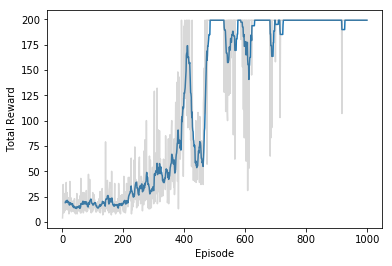

In [23]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


[2017-08-30 17:28:22,895] Restoring parameters from checkpoints/cartpole.ckpt


In [25]:
env.close()

In [26]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.